<a href="https://colab.research.google.com/github/IvanNN19/Myasnov_product_analysis/blob/main/%D0%9C%D1%8F%D1%81%D0%BD%D0%BE%D0%B2_%D0%BF%D1%80%D0%BE%D0%B4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###Тут небольшой readme проекта. Данное решение было создано для построения трендов цен конкурентов магазина Мяснов.



#Первая ячейка импортирует из большого файлика с ценами конкурентов данные, удаляет ненужные столбцы, преобразовывает названия других столбцов, форматирует даты, запоминает в массив dates все даты из файла. При необходимости можем считать информацию про SKU-продукта.

In [62]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from datetime import timedelta
from datetime import datetime
read_df = pd.read_excel('/content/drive/MyDrive/Выгрузка по проекту Хлеб за 3 месяца.xlsx')

# read_df = pd.read_csv('/content/drive/MyDrive/for_example(31-13).csv', sep=';', low_memory=False)
# read_sku_df = pd.read_excel('/content/drive/MyDrive/proverka.xlsx')

read_df = read_df.drop(columns=['Unnamed: 1', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'])
# Создание списка дат из колонок
dates = []
old_dates = read_df.iloc[2].iloc[10::3]  # Получаем все даты из исходного df (каждую 4-ую колонку, начиная с 3-й)
for d in old_dates:
  date_obj = datetime.strptime(d, "%d.%m.%Y")
  formatted_date = date_obj.strftime("%Y.%m.%d")
  dates.append(formatted_date)
read_df.rename(columns = {'Unnamed: 0':'artic_m', 'Unnamed: 5':'sku_prod', 'Unnamed: 7':'region', 'Unnamed: 8':'market'}, inplace = True )
read_df_old = read_df

In [63]:
# read_df.head(10)

#Во второй ячейке пользователь вводит следующие начальные данные:

1.   Артикул на товар(товары)
2.   Кг или Литры(костыль, а что поделать)
3.   Временной отрезок для анализа
4.   Регион
5.   Маркет

#В этом блоке мы создаем облегченный DF, в котором только необходимые поля. Если хотим поменять вводные параметры, нужно запускать ячейку снова.


In [69]:
read_df = read_df_old
print("Напишите артикул(пока только один) товара из Ассортимента Мяснов. Нпример, 90000560")
# user_input = 90000560 #int
art_array = []
# user_input = input()
art_array = list(map(int, input().split()))
msk = read_df['artic_m'].isin(art_array)
read_df = read_df[msk]
print('-------------------------------------------------')
for i, s in enumerate(read_df.sku_prod.unique()):
  print('Наши товары:', str(read_df.sku_prod.unique()[i]))
print('-------------------------------------------------')

print('Что будет: кг-1 или литры-2(батон - кг, молоко - литры)')
n = 1
mas = ['килограмм', 'литр']

print('Угу, теперь временной отрезок(Наример: 19.05.24-11.08.24)без пробелов')
# date_range_str = input()
date_range_str = '19.05.24-11.08.24'
start_date_str, end_date_str = date_range_str.split('-')
# Преобразование строк в объекты datetime
start_date = datetime.strptime(start_date_str, "%d.%m.%y")
end_date = datetime.strptime(end_date_str, "%d.%m.%y")
# Создание массива из двух переменных
date_range = [start_date, end_date]

# array_msk = read_df[read_df.region == 'moscow'].market.unique()
# array_nn = read_df[read_df.region == 'nizhny_novgorod'].market.unique()

print('52 -> 1')
print('77 -> 2')
# print("55 + 77 -> 3")
a = int(input())
if a == 1:
  reg_array = ['nizhny_novgorod']
  store = read_df[read_df.region == reg_array[0]].market.unique()
else:
  reg_array = ['moscow']
  store = read_df[read_df.region == reg_array[0]].market.unique()

print('Выберете маркет. Просто напишите его номер')
for i, st in enumerate(store, 1):
    print(f"{i}. {st}")

store_array = []
user_input = input()
help_array = list(map(int, user_input.split()))
for a in help_array:
  store_array.append(store[a-1])

print(store_array)

Напишите артикул(пока только один) товара из Ассортимента Мяснов. Нпример, 90000560
90000560
-------------------------------------------------
Наши товары: батон МЪ ПЕКАРНЯ в уп.цел.пак. 400г (нарезка)
-------------------------------------------------
Что будет: кг-1 или литры-2(батон - кг, молоко - литры)
Угу, теперь временной отрезок(Наример: 19.05.24-11.08.24)без пробелов
52 -> 1
77 -> 2
2
Выберете маркет. Просто напишите его номер
1. online.metro-cc.ru
2. av.ru
3. okeydostavka.ru
4. myspar.ru
5. auchan.ru
6. vkusvill.ru
7. dostavka.5ka.ru
8. perekrestok.ru
9. dostavka.dixy.ru
10. magnit.ru
11. online.globus.ru
12. lavka.yandex.ru
13. vprok.ru
14. utkonos.ru
15. chizhik.club
4 5
['myspar.ru', 'auchan.ru']


# Конвертация таблицы конкурентов
##В этом блоке мы преобразовывем отчищаем и заполняем DF и создаем удобный формат для визуализации через matplotlib.
##Есть параметр kof - он отвечает за то, от какого количества недель товар стабильно представлен в маркете, а не просто разовая демонстрация продукта. Если меньше этого параметра - будут просто точки на графике, но если больше - пустые поля на цены продукта заполним последней ценой.

In [71]:
#Наложение фильтра Регион + Маркет
mask = ((read_df['region'].isin(reg_array)) & read_df['market'].isin(store_array))
df = read_df[mask]
df = df.drop(columns=['artic_m', 'sku_prod'])

n = df.shape[0]
cnt = (df.shape[1] - 7)//3

data = []
bad_data = []
cost = [0] * cnt
bad_prod = []

kof = 0.2
print(n, cnt)
# пока пишем говно-код потом переделаем если оно будет работать
for i in range(n): #пробегаемся по всем товарам
  h = 0
  for j in range(cnt):#по ценам на каждый товар
    if pd.notnull(df.iloc[i, 7 + (j * 3)]):
      cost[j] = df.iloc[i, 7 + (j * 3)]
  for j in range(len(cost)):
    count_non_zero = sum(1 for num in cost if num != 0)
    first_non_zero_index = next((i for i, num in enumerate(cost) if num != 0), None)

    if count_non_zero > int(cnt*kof):
      if first_non_zero_index != 0:
        for h in range(0, first_non_zero_index):
          cost[h] = cost[first_non_zero_index]
      else:
        if cost[j] == 0:
          cost[j] = cost[j-1]
      row = {
      "товар": df.iloc[i].iloc[0],
      "регион": df.iloc[i].iloc[1],
      "цена": cost[j],
      "маркет": df.iloc[i].iloc[2],
      "дата": dates[j],
      "SKU-Продукты/Цена52": df.iloc[i].iloc[3],
      "SKU-Продукты/Цена77": df.iloc[i].iloc[4],
      "SKU-Продукты/Цена За КГ_Л 52": df.iloc[i].iloc[5],
      "SKU-Продукты/Цена За КГ_Л 77": df.iloc[i].iloc[6]
      }
      data.append(row)
    else:
      if cost[j] != 0:
        row = {
        "товар": df.iloc[i].iloc[0],
        "регион": df.iloc[i].iloc[1],
        "цена": cost[j],
        "дата": dates[j],
        "маркет": df.iloc[i].iloc[2],
        "SKU-Продукты/Цена52": df.iloc[i].iloc[3],
        "SKU-Продукты/Цена77": df.iloc[i].iloc[4],
        "SKU-Продукты/Цена За КГ_Л 52": df.iloc[i].iloc[5],
        "SKU-Продукты/Цена За КГ_Л 77": df.iloc[i].iloc[6]
        }
        bad_data.append(row)
  cost = [0] * cnt
  result_df = pd.DataFrame(data)
  bad_result_df = pd.DataFrame(bad_data)

result_df = result_df.sort_values(by = ['дата'], ascending=[True])
# result_df.to_excel('after.xlsx')

20 14


#подготовка мяснова

#Рисуем график тренда цены. Тут все просто и максимально просторно

[9 9 9 9 9 9 9 9 9 9 9 9 9 9]
[10 10 10 10 10 10 10 10 10 10 10 10 10 10]


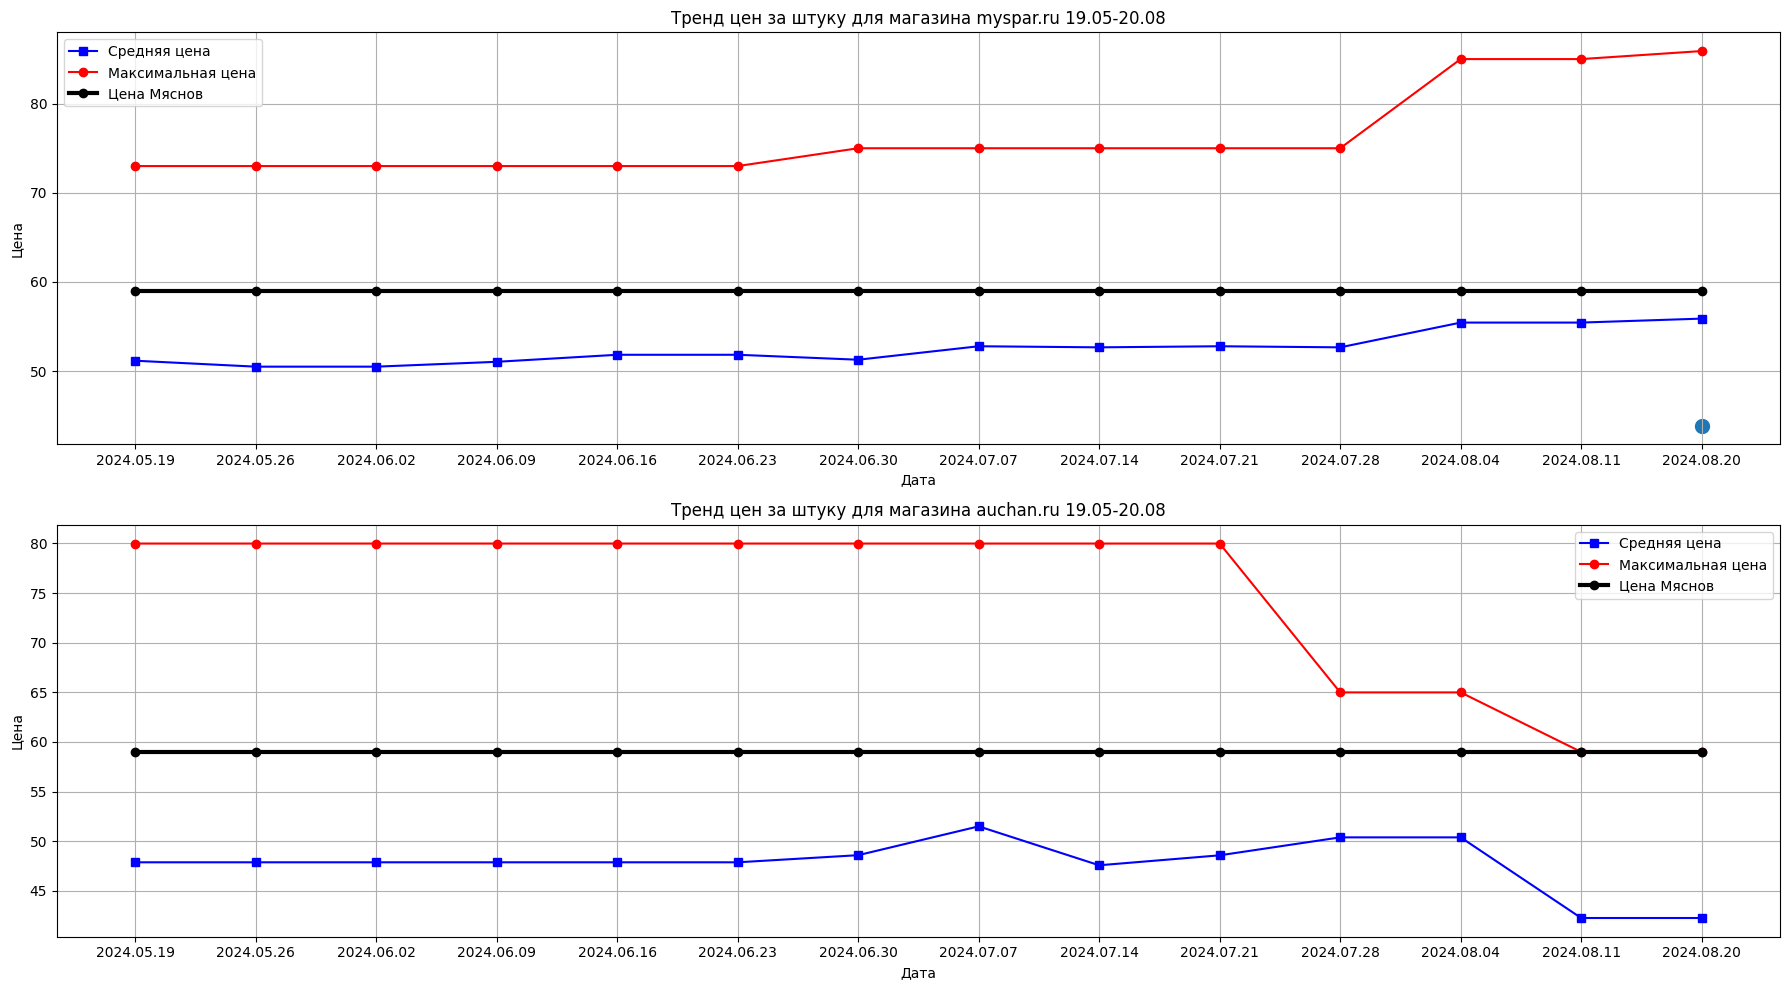

In [75]:
#Делаем матрички резов для каждого магазина & graf Новая визуализация
fig, axes = plt.subplots(nrows=len(store_array) * 1, ncols=1, figsize=(18, len(store_array) * 5))
i = 0
for store in store_array:
  #Делаем матрички резов
  ndf = result_df.groupby(['маркет', 'дата']).agg({'цена' : ['max', 'mean', 'count']})
  myasnov_df = result_df.groupby(['маркет', 'дата']).agg({'SKU-Продукты/Цена77' : ['mean']})

  store_a_df = ndf.loc[store]
  myasnov_price = myasnov_df.loc[store]['SKU-Продукты/Цена77']['mean'].to_numpy()

  # Создание матрицы для цены за штуку n x m (n = количество записей, m = 3 столбца: Дата, Средняя цена, Максимальная цена)
  mean_prices = store_a_df['цена']['mean'].to_numpy()
  max_prices = store_a_df['цена']['max'].to_numpy()
  count_prices = store_a_df['цена']['count'].to_numpy()

  matrix = np.empty((len(dates), 3), dtype=object)
  matrix[:, 0] = dates
  matrix[:, 1] = mean_prices
  matrix[:, 2] = max_prices

  # Извлекаем данные из матрицы_за штуку
  dates = matrix[:, 0]  # Столбец с датами
  mean_prices = matrix[:, 1].astype(float)  # Столбец со средними ценами (преобразуем в float)
  max_prices = matrix[:, 2].astype(float)   # Столбец с максимальными ценами (преобразуем в float)

# Первый график: Цена на товар shtuka
  axes[i].plot(dates, mean_prices, marker='s', label='Средняя цена', color='blue')
  axes[i].plot(dates, max_prices, marker='o', label='Максимальная цена', color='red')
  axes[i].plot(dates, myasnov_price, marker='o', label='Цена Мяснов', linewidth= 3, color='black')
  axes[i].scatter(bad_result_df[bad_result_df['маркет'] == store]['дата'], bad_result_df[bad_result_df['маркет'] == store]['цена'], linewidth= 5)

  print(count_prices)
  # Настройки графика
  axes[i].set_title('Тренд цен за штуку для магазина %s 19.05-20.08' %store)
  axes[i].set_ylabel('Цена')
  axes[i].set_xlabel('Дата')
  axes[i].grid(True)
  axes[i].legend()

  # i+=2
  i+=1

# Показать график
plt.tight_layout()
plt.show()
